## Sentiment Analysis and Root Cause Detection using NLP techniques

### Importing necessary libraries

In [1]:
import pandas as pd 
from langdetect import detect
from googletrans import Translator
import seaborn as sns 
import matplotlib.pyplot as plt 
import warnings
warnings.filterwarnings("ignore")
from wordcloud import WordCloud
import nltk
from nltk.util import ngrams
from rake_nltk import Rake
import yake 
from nltk.corpus import stopwords
from collections import Counter
from nltk.tokenize import word_tokenize
from string import punctuation
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.metrics import silhouette_score
from gensim.models import Word2Vec
from sklearn.cluster import KMeans
import contractions
from string import punctuation
from unidecode import unidecode
from nltk.stem import WordNetLemmatizer
import numpy as np

In [2]:
# Creating a dataframe

data = pd.read_csv("dataset_es_train.csv")
data.head(2)

,review_id,product_id,reviewer_id,stars,review_body,review_title,language,product_category
0,es_0491108,product_es_0296024,reviewer_es_0999081,1,Nada bueno se me fue ka pantalla en menos de 8...,television Nevir,es,electronics
1,es_0869872,product_es_0922286,reviewer_es_0216771,1,"Horrible, nos tuvimos que comprar otro porque ...",Dinero tirado a la basura con esta compra,es,electronics


In [3]:
np.random.seed(42)

final_data = data.sample(1000)

In [4]:
# selecting only review body and stars columns

final_data = final_data[['review_body','stars']]

In [5]:
final_data.reset_index(drop=True,inplace=True)

In [6]:
final_data

,review_body,stars
0,Mini usb cable de carga defectuoso por lo cual...,3
1,El cable es muy largo y es comodo pero me duró...,2
2,Ideal para mis necesidades.,4
3,"Es desigual el color, y mancha. El hilo de rom...",2
4,Los comentarios se hacen cuando uno recibe la ...,1
...,...,...
995,Supongo que habrá quién le haya sacado provech...,1
996,Instrucciones en inglés.,1
997,las amarillas no me han gustado mucho.,2
998,"El producto es muy bonito, pero nos ha llegado...",2


In [7]:
# checking data types

final_data.dtypes

review_body    object
stars           int64
dtype: object

## Initial pre-processing
- language detection
- language translation(to English)

In [8]:
# language detection

def lang_detection(data):
    lang = detect(data)
    return lang

In [9]:
final_data['language'] = final_data['review_body'].apply(lang_detection)

In [10]:
final_data.head()

,review_body,stars,language
0,Mini usb cable de carga defectuoso por lo cual...,3,es
1,El cable es muy largo y es comodo pero me duró...,2,es
2,Ideal para mis necesidades.,4,es
3,"Es desigual el color, y mancha. El hilo de rom...",2,es
4,Los comentarios se hacen cuando uno recibe la ...,1,es


In [11]:
final_data['language'].value_counts()

es    975
pt     16
en      2
it      2
ca      2
fr      1
sk      1
af      1
Name: language, dtype: int64

In [12]:
# lang translation

def lang_translation(data):
    translator = Translator()
    clean_text = translator.translate(data)
    return clean_text.text

In [13]:
# from translate import Translator

# def lang_translation(text, src_lang='es', dest_lang='en'):
#     """
#     Translates a given text to English using an offline translation model.

#     Parameters:
#         text (str): The text to be translated.
#         src_lang (str): The source language code (e.g., 'es' for Spanish).
#         dest_lang (str): The destination language code (e.g., 'en' for English).

#     Returns:
#         str: The translated text in English.
#     """
#     translator = Translator(from_lang=src_lang, to_lang=dest_lang)
#     translated_text = translator.translate(text)
#     return translated_text

In [14]:
# first row of the data

final_data['review_body'][0]

'Mini usb cable de carga defectuoso por lo cual se estropearon los usb de las baterias'

In [15]:
# translating first row to English

lang_translation(final_data['review_body'][0])

'Mini USB defective load cable so the USB of batteries were broken'

In [16]:
final_data['review_body'][1]

'El cable es muy largo y es comodo pero me duró poco tiempo porque el conector microusb se me acabó doblando'

In [17]:
lang_translation(final_data['review_body'][1])

'The cable is very long and it is comfortable but it lasted a short time because the microusb connector ended up folding'

In [18]:
# translating review_body column to English and saving traslated reviews as translated_review column

final_data['translated_review'] = final_data['review_body'].apply(lang_translation)

In [19]:
final_data.head()

,review_body,stars,language,translated_review
0,Mini usb cable de carga defectuoso por lo cual...,3,es,Mini USB defective load cable so the USB of ba...
1,El cable es muy largo y es comodo pero me duró...,2,es,The cable is very long and it is comfortable b...
2,Ideal para mis necesidades.,4,es,Ideal for my needs.
3,"Es desigual el color, y mancha. El hilo de rom...",2,es,"The color, and stain is unequal.The thread of ..."
4,Los comentarios se hacen cuando uno recibe la ...,1,es,Comments are made when one receives the mercha...


## EDA
####  Here to understand our data we observed ***unigrams***, ***bigrams*** and ***trigrams***.
#### This gave us understanding of most frequent words and domain specific stopwords.
#### We understood positive and negative words, and also, we got some idea about potential root causes**

In [20]:
# Download the stopwords for English

nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Akshay\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [21]:
# checking stopwords for English language

stopwordlist =  stopwords.words("english")

In [22]:
stopwordlist

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

In [23]:
# We don not want to remove words 'not', 'nor', 'no' as they help us understand the negative reviews. So we remove these words from our stopwordslist.

stopwordlist.remove('not')
stopwordlist.remove('nor')
stopwordlist.remove('no')

In [24]:
# The 'punkt' package contains data necessary for word and sentence tokenization.

nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Akshay\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [25]:
# Creating a function to extract unigrams,bigrams and trigrams

def extract_ngrams(data,ngram_range):
    tokens = [word.lower() for word in word_tokenize(data) if (word not in punctuation) and (word.isalpha()) and (word.lower() not in stopwordlist)]
    ngrams_list = ngrams(tokens,ngram_range)
    final_ngrams = []
    for words in ngrams_list:
        final_ngrams.append(" ".join(words))
    return final_ngrams

In [26]:
unigram_list = final_data['translated_review'].apply(lambda x :extract_ngrams(x,1) )

#### Unigrams gives most frequent words. It gives understanding of domain specific stopwords. We Have to use common sense. Domain expertise can help with domain specific stopwords. 

In [27]:
# Observing most common words (unigrams)

final_unigram = []
for unigram in unigram_list:
    final_unigram.extend(unigram)
top_25_unigrams = Counter(final_unigram).most_common(100)
top_25_unigrams

[('not', 591),
 ('good', 225),
 ('quality', 134),
 ('well', 130),
 ('product', 109),
 ('price', 99),
 ('without', 79),
 ('like', 78),
 ('time', 77),
 ('little', 73),
 ('one', 71),
 ('use', 70),
 ('put', 69),
 ('perfect', 64),
 ('would', 59),
 ('bad', 57),
 ('although', 56),
 ('also', 54),
 ('bought', 54),
 ('buy', 52),
 ('two', 50),
 ('lot', 50),
 ('expected', 48),
 ('much', 48),
 ('since', 47),
 ('comfortable', 44),
 ('quite', 44),
 ('seems', 44),
 ('recommend', 44),
 ('give', 43),
 ('case', 41),
 ('no', 39),
 ('return', 39),
 ('come', 39),
 ('purchase', 39),
 ('another', 38),
 ('easy', 37),
 ('something', 37),
 ('first', 36),
 ('came', 36),
 ('take', 36),
 ('arrived', 34),
 ('used', 34),
 ('small', 34),
 ('fine', 34),
 ('battery', 33),
 ('work', 33),
 ('cover', 33),
 ('already', 33),
 ('perfectly', 33),
 ('works', 32),
 ('screen', 32),
 ('happy', 30),
 ('beautiful', 30),
 ('size', 30),
 ('bit', 29),
 ('get', 29),
 ('broken', 28),
 ('think', 28),
 ('plastic', 28),
 ('better', 28),
 ('

In [28]:
# Creating a function to generate a wordcloud to better communicate our findings with the stakeholders

def generate_wordcloud(data,column):
    df = data[column].str.cat(sep=" ") # record1   record 2 
    text = " ".join([word for word in df.split()])# 
    word_cloud = WordCloud(height=500,width=700,background_color='white',min_font_size=10).generate(text)
    plt.figure(figsize=(10,16))
    plt.imshow(word_cloud)
    plt.axis("off")
    plt.show()

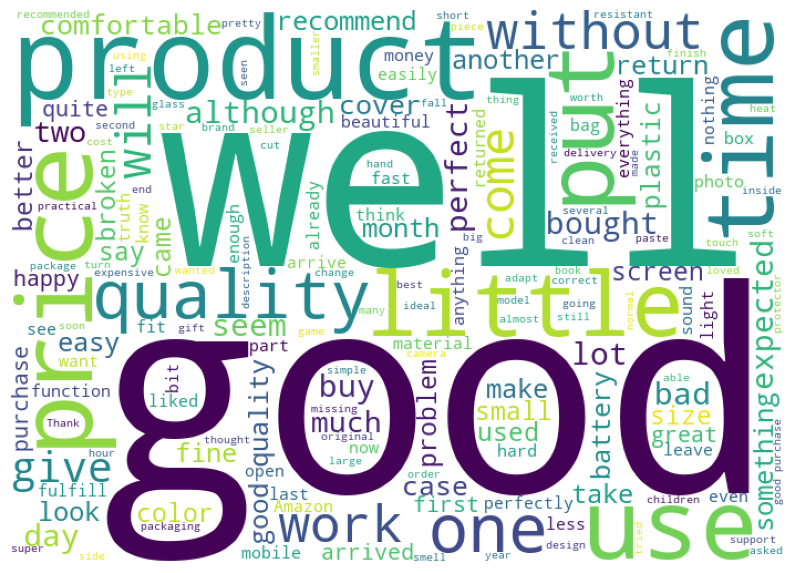

In [29]:
# In wordcloud size of each word indicates its frequency or importance.

generate_wordcloud(final_data,'translated_review')

## Text Pre-processing

In [30]:
# 1. remove blanklines,whitespaces,tabs 
def remove_spaces(data):
    "Function will remove all spaces"
    formatted_text = data.replace('\\n',' ').replace('\t',' ').replace("\\",' ')
    return formatted_text 

# 2. Contraction mapping 
def expand_text(data):
    fixed_text = contractions.fix(data)
    return fixed_text

# 3. Handling accented 
def handling_accented(data):
    fixed_text = unidecode(data)
    return fixed_text

# 4.cleaning 
stopword_list = stopwords.words("english")
stopword_list.remove("not")
stopword_list.remove("nor")
stopword_list.remove("no")

def cleaning(data):
    tokens = word_tokenize(data) # tokenization
    clean_text = [word.lower() for word in tokens if (word not in stopword_list) and(word not in punctuation) and(len(word)>2) and(word.isalpha())]
    return clean_text

# 5. autocorrect 
def autocorrection(data):
    spell = Speller(lang='en')
    corrected_text = spell(data)
    return corrected_text

# 6. Lemmatization 
def lemmatization(data):
    lemmatizer = WordNetLemmatizer()
    final_text = []
    for word in data:
        lemmatized_word = lemmatizer.lemmatize(word)
        final_text.append(lemmatized_word)
    return " ".join(final_text)

In [31]:
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Akshay\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [32]:
clean_text = final_data['translated_review'].apply(remove_spaces)
clean_text = clean_text.apply(expand_text)
clean_text = clean_text.apply(handling_accented)
clean_text = clean_text.apply(cleaning)
clean_text = clean_text.apply(lemmatization)

## Feature Engineering

In [33]:
# Vectorization

# 1. Count vectorizer

count_vec = CountVectorizer()
bow = count_vec.fit_transform(clean_text).A   # The .A attribute converts the resulting sparse matrix into a dense NumPy array.
pd.DataFrame(bow,columns=count_vec.get_feature_names_out())

,abandoned,able,abolished,abroad,absence,absolutely,absorb,absurd,accept,acceptable,...,yesterday,yet,yorkshire,you,young,youtube,zapatillas,zero,zipper,zone
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
996,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
997,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
998,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [34]:
# 2. Tfidf vectorizer

tfidf_vec = TfidfVectorizer()
tfidf_val = tfidf_vec.fit_transform(clean_text).A
pd.DataFrame(tfidf_val,columns=tfidf_vec.get_feature_names_out())

,abandoned,able,abolished,abroad,absence,absolutely,absorb,absurd,accept,acceptable,...,yesterday,yet,yorkshire,you,young,youtube,zapatillas,zero,zipper,zone
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
996,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
997,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
998,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [35]:
# [[w1,w2],[]]
sent = clean_text.tolist()
final_text = [sen.split() for sen in sent]  # [[],[]]
final_text

[['mini', 'usb', 'defective', 'load', 'cable', 'usb', 'battery', 'broken'],
 ['the',
  'cable',
  'long',
  'comfortable',
  'lasted',
  'short',
  'time',
  'microusb',
  'connector',
  'ended',
  'folding'],
 ['ideal', 'need'],
 ['the', 'color', 'stain', 'thread', 'break', 'easily', 'think', 'come', 'le'],
 ['comment',
  'made',
  'one',
  'receives',
  'receiving',
  'impossible',
  'arrives',
  'monday',
  'day',
  'late'],
 ['after',
  'waiting',
  'product',
  'month',
  'send',
  'tell',
  'stock',
  'return',
  'say',
  'not',
  'tell',
  'sale',
  'these',
  'chinese',
  'unpresentable',
  'save',
  'eur',
  'then',
  'happens',
  'happens'],
 ['apparently',
  'long',
  'treatment',
  'two',
  'month',
  'rest',
  'two',
  'product',
  'intake',
  'not',
  'benefit',
  'anymore',
  'body',
  'eliminates',
  'carry',
  'everything',
  'say',
  'personally',
  'noticed',
  'improvement',
  'truth',
  'also',
  'resumed',
  'physical',
  'activity',
  'bike',
  'gym',
  'abandone

In [36]:
# 3. word2vec

word2vec_model = Word2Vec(final_text,min_count=2,window=6)

In [37]:
# save model 

word2vec_model.save("Word2vec.model")

In [38]:
# model.wv : vocabulary 

In [39]:
# doc vect = vect1+ vect2/2
def vectorizer(list_docs,model):
    feature = [] # we will save vector of a document 
    for doc in list_docs : # iterate over all the reviews 
        zero_vector = np.zeros(model.vector_size) #  zero vector for handling key error
        vectors = []
        for word in doc :
            if word in model.wv : # it just checks if word is present or not in models vocabulary
                try : 
                    vectors.append(model.wv[word])
                except KeyError :
                    continue
        if vectors :
            vectors = np.asarray(vectors)
            avg_vec = vectors.mean(axis=0)
            feature.append(avg_vec)
        else :
            feature.append(zero_vector)
    return feature

In [40]:
vectorized_docs = vectorizer(final_text,word2vec_model)

In [41]:
x_emb = np.array(vectorized_docs)
x_emb

array([[-0.01352571,  0.0540974 ,  0.0181194 , ..., -0.0306341 ,
         0.01081531, -0.01052256],
       [-0.01718334,  0.07022226,  0.02501756, ..., -0.04224852,
         0.02016297, -0.01498613],
       [-0.0133714 ,  0.05129258,  0.01581295, ..., -0.03342956,
         0.01614844, -0.00751517],
       ...,
       [-0.06525764,  0.23455635,  0.08902057, ..., -0.14299166,
         0.06380758, -0.04347086],
       [-0.03428072,  0.11337894,  0.04092962, ..., -0.0686058 ,
         0.02993274, -0.02481766],
       [-0.01476309,  0.031238  ,  0.0140953 , ..., -0.02439885,
         0.00974323, -0.01386557]])

## Clustering 

In [42]:
# kmeans 
def build_kmeans(clusters,data):
    kmeans_model = KMeans(n_clusters=clusters)
    y_pred = kmeans_model.fit_predict(data)
    return kmeans_model,y_pred

In [43]:
# kmeans- count 
bow_kmeans_model,bow_pred = build_kmeans(3,bow)

In [44]:
# kmeans-tfidf 
tfidf_kmeans_model,tfidf_pred = build_kmeans(3,tfidf_val)

In [45]:
# kmeans-word2vec
word2vec_kmeans_model,word2vec_pred = build_kmeans(3,x_emb)

## Evaluation

**The silhouette value is a measure of how similar an object is to its own cluster (cohesion) compared to other clusters (separation).
The silhouette ranges from −1 to +1, where a high value indicates that the object is well matched to its own cluster and poorly matched to neighboring clusters.**

In [46]:
# evaluation with silhouette 
print(f"silhouette score with KMeans- count {silhouette_score(bow,bow_pred)}")
print(f"silhouette score with KMeans- tfidf  {silhouette_score(tfidf_val,tfidf_pred)}")
print(f"silhouette score with KMeans- word2vec {silhouette_score(x_emb,word2vec_pred)}")

silhouette score with KMeans- count 0.22499637558123628
silhouette score with KMeans- tfidf  0.006688674388420665
silhouette score with KMeans- word2vec 0.5025171630949119


In [47]:
# silhouette visualizeer 
from yellowbrick.cluster import SilhouetteVisualizer

def visualize_silhouette(data,model,title):
    visualizer = SilhouetteVisualizer(model,colors='yellowbrick')
    visualizer.fit(data)
    plt.title(f"Silhouette visualizer with {title}")

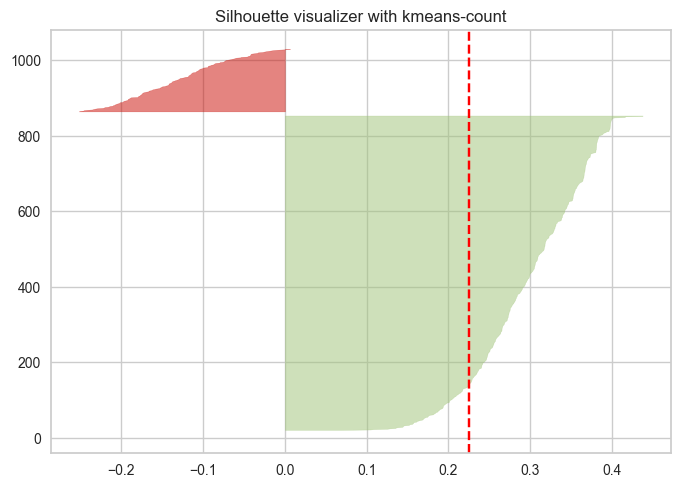

In [48]:
# kmeans count 
visualize_silhouette(bow,bow_kmeans_model,"kmeans-count")   # all our clusters should be on positive. red line is centroid

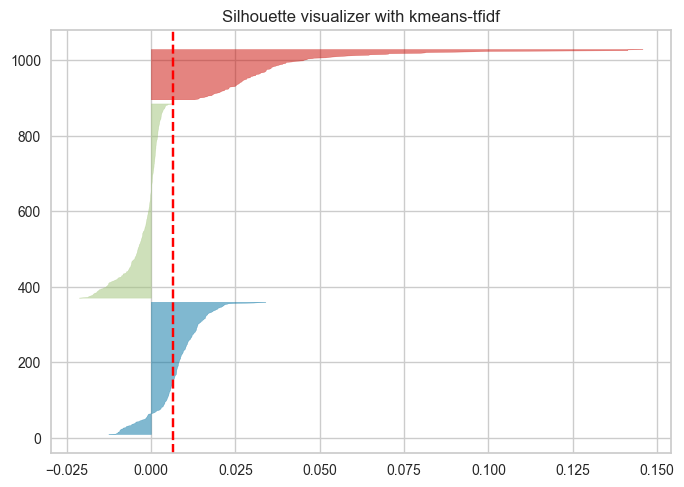

In [49]:
# tfidf
visualize_silhouette(tfidf_val,tfidf_kmeans_model,"kmeans-tfidf")

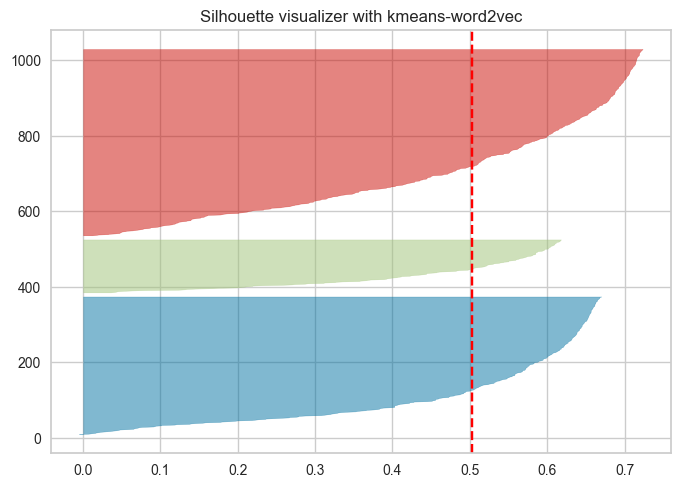

In [50]:
# word2vec
visualize_silhouette(x_emb,word2vec_kmeans_model,"kmeans-word2vec")

In [51]:
# target column
word2vec_pred

array([0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 0, 0, 2, 2, 2, 0, 2, 2, 1, 2, 2, 1,
       2, 0, 2, 2, 2, 0, 2, 2, 2, 0, 1, 0, 0, 2, 0, 0, 2, 2, 2, 0, 2, 0,
       0, 2, 1, 2, 2, 1, 2, 0, 2, 2, 0, 0, 2, 0, 0, 2, 2, 0, 2, 2, 2, 2,
       2, 2, 0, 2, 1, 0, 1, 0, 2, 0, 2, 0, 0, 0, 2, 2, 1, 1, 2, 2, 0, 0,
       2, 2, 1, 0, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 0, 2, 0, 1, 0, 2, 1, 0,
       0, 0, 0, 0, 2, 2, 0, 2, 2, 0, 0, 2, 0, 0, 2, 2, 2, 0, 0, 2, 0, 1,
       2, 2, 2, 0, 2, 2, 0, 2, 0, 2, 0, 2, 0, 2, 2, 1, 2, 2, 0, 2, 2, 0,
       2, 0, 2, 0, 0, 2, 0, 2, 0, 1, 2, 2, 0, 0, 1, 2, 1, 2, 2, 0, 0, 2,
       2, 2, 2, 2, 0, 0, 2, 1, 2, 2, 0, 2, 1, 2, 2, 0, 1, 0, 0, 0, 2, 0,
       2, 0, 1, 2, 2, 0, 2, 2, 0, 2, 1, 0, 2, 2, 2, 2, 1, 1, 0, 2, 0, 0,
       2, 2, 1, 2, 2, 1, 2, 0, 0, 0, 0, 2, 2, 2, 0, 0, 0, 2, 0, 1, 2, 0,
       2, 2, 0, 2, 1, 2, 0, 2, 0, 2, 2, 1, 2, 1, 1, 2, 0, 2, 2, 0, 0, 2,
       2, 0, 1, 2, 1, 0, 2, 2, 0, 2, 2, 0, 1, 2, 0, 1, 0, 1, 0, 2, 0, 0,
       1, 1, 0, 1, 2, 0, 2, 0, 0, 0, 2, 0, 2, 2, 1,

## Model building

In [55]:
len(x_emb)

1000

In [56]:
len(word2vec_pred)

1000

In [57]:
x_emb.shape

(1000, 100)

In [58]:
word2vec_pred.shape

(1000,)

In [74]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

data = {'x_emb': x_emb.tolist(),'word2vec_pred': word2vec_pred.tolist()}
df = pd.DataFrame(data)
df

,x_emb,word2vec_pred
0,"[-0.013525710441172123, 0.05409740284085274, 0...",0
1,"[-0.0171833373606205, 0.07022225856781006, 0.0...",0
2,"[-0.01337139680981636, 0.05129258334636688, 0....",0
3,"[-0.02172890305519104, 0.08459813892841339, 0....",0
4,"[-0.015258421190083027, 0.05683445185422897, 0...",0
...,...,...
995,"[-0.03603789582848549, 0.12589621543884277, 0....",2
996,"[-0.0014087669551372528, 0.031509146094322205,...",0
997,"[-0.06525763869285583, 0.23455634713172913, 0....",1
998,"[-0.034280724823474884, 0.11337894201278687, 0...",2


In [72]:
df.to_csv('Xydf.csv')

In [75]:
# Preprocess the Data
X = np.array(df['x_emb'].tolist())  # Convert 'x_emb' column to a 2D NumPy array (feature matrix)
y = np.array(df['word2vec_pred'])   # Convert 'word2vec_pred' column to a 1D NumPy array (target labels)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the Random Forest classifier
lr_model = LogisticRegression(random_state=42)
lr_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = lr_model.predict(X_test)

# Evaluate the model's performance
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

Accuracy: 0.93


In [73]:
# Preprocess the Data
X = np.array(df['x_emb'].tolist())  # Convert 'x_emb' column to a 2D NumPy array (feature matrix)
y = np.array(df['word2vec_pred'])   # Convert 'word2vec_pred' column to a 1D NumPy array (target labels)

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Initialize and train the Random Forest classifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = rf_model.predict(X_test)

# Evaluate the model's performance
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

Accuracy: 1.0


## Pickle file

In [76]:
import pickle

# Save the model to a pickle file
with open('lr_model.pickle', 'wb') as f:
    pickle.dump(lr_model, f)

## Root Cause Analysis

In [51]:
# root cause analysis
final_data.translated_review[:3]

0    Mini USB defective load cable so the USB of ba...
1    The cable is very long and it is comfortable b...
2                                  Ideal for my needs.
Name: translated_review, dtype: object

In [52]:
# rake 
from rake_nltk import Rake
rake_extractor = Rake()
rake_extractor.extract_keywords_from_text(final_data.translated_review[0])
keyphrases = rake_extractor.get_ranked_phrases()

In [53]:
final_data.translated_review[0]

'Mini USB defective load cable so the USB of batteries were broken'

In [54]:
import yake

In [55]:
kw_extractor = yake.KeywordExtractor()
keywords = kw_extractor.extract_keywords(final_data.translated_review[0])
keywords

[('Mini USB defective', 0.0027455531884318),
 ('USB defective load', 0.004579264459893852),
 ('defective load cable', 0.006822309199625383),
 ('Mini USB', 0.014348192077153755),
 ('batteries were broken', 0.021114872146320036),
 ('USB defective', 0.0236716783606844),
 ('defective load', 0.03498702377830618),
 ('load cable', 0.03498702377830618),
 ('USB of batteries', 0.05593421267454367),
 ('USB', 0.06288576087144737),
 ('Mini', 0.11246769819744629),
 ('broken', 0.11246769819744629),
 ('defective', 0.1838594885424691),
 ('load', 0.1838594885424691),
 ('cable', 0.1838594885424691),
 ('batteries', 0.1838594885424691)]

In [56]:
list_keyphrase = [kw[0] for kw in keywords[:4]]

In [57]:
list_keyphrase = [sen.split() for sen in list_keyphrase]

In [58]:
list_keyphrase

[['Mini', 'USB', 'defective'],
 ['USB', 'defective', 'load'],
 ['defective', 'load', 'cable'],
 ['Mini', 'USB']]

In [59]:
# doc vect = vect1+ vect2/2
def vectorizer(list_docs,model):
    feature = [] # we will save vector of a document 
    for doc in list_docs : # iterate over all the reviews 
        zero_vector = np.zeros(model.vector_size) #  zero vector for handling key error
        vectors = []
        for word in doc :
            if word in model.wv : # it just checks if word is present or not in models vocabulary
                try : 
                    vectors.append(model.wv[word])
                except KeyError :
                    continue
        if vectors :
            vectors = np.asarray(vectors)
            avg_vec = vectors.mean(axis=0)
            feature.append(avg_vec)
        else :
            feature.append(zero_vector)
    return feature

In [60]:
keyphrase_vectors = vectorizer(list_keyphrase,word2vec_model)

In [61]:
vect1 = keyphrase_vectors[0]
vect2 = keyphrase_vectors[1]

In [62]:
keyphrase_list = [kw[0] for kw in keywords[:2]]

In [63]:
keyphrase_list

['Mini USB defective', 'USB defective load']

In [64]:
import numpy as np
from numpy.linalg import norm

# cosine_score = (np.dot(vect1,vect2))/(norm(vect1)*norm(vect2))
dict1 = {}

for index,kw1 in enumerate(keyphrase_list) : # iterate over keyphrases

    for kw2 in keyphrase_list: # iterate over keyphrases
    
        list_keyphrase = list((kw1.split(),kw2.split())) # [[],[]]
        keyphrase_vectors = vectorizer(list_keyphrase,word2vec_model) # vectors extraction of  keyphrases
        vect1 = keyphrase_vectors[0]
        vect2 = keyphrase_vectors[1]
        cosine_score = (np.dot(vect1,vect2))/(norm(vect1)*norm(vect2)) # cosine similarity between each and every keyphrase
        if cosine_score>0.85 : 
            dict1[index] = [kw1,kw2]
            print(dict1)



{0: ['Mini USB defective', 'Mini USB defective']}
{0: ['Mini USB defective', 'USB defective load']}
{0: ['Mini USB defective', 'USB defective load'], 1: ['USB defective load', 'Mini USB defective']}
{0: ['Mini USB defective', 'USB defective load'], 1: ['USB defective load', 'USB defective load']}


In [65]:
dict1

{0: ['Mini USB defective', 'USB defective load'],
 1: ['USB defective load', 'USB defective load']}

In [66]:
{'delete' : ['stop deleting', 'deleting the data']} 

{'delete': ['stop deleting', 'deleting the data']}